**Phase 3 running final data against Phase 2 Models---9/7/2019**
___
Phase 3 Items Covered

- Use balanced sample of 50K observations DONE
- Align features across scripts DONE 
- Substitute dummies for label encoding, create a pipeline DONE except for two where I need guarateed "1" values DONE
- Add CV with 12 folds and randomized splits DONE
- Review validation curve DONE
- Precision and Recall DONE
- Grid search DONE
- Analyses on all years DONE

In [3]:
%matplotlib inline 

import os
import psycopg2
import json 
import time
import pickle
import pandas as pd 
import seaborn as sns

from sklearn.datasets.base import Bunch
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.exceptions import NotFittedError
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold #ensure allows for randomization
from sklearn.model_selection import train_test_split as tts #drop this if using KFold
from sklearn import preprocessing
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [ ]:
con = psycopg2.connect(host="",database="", user="", password="", port="5432")
cur = con.cursor()
cur.execute("SET search_path TO interim_datasets_v2")

In [5]:
query_statement = '''SELECT * FROM interim_hmda_2010_2017_union_srandom_bal_200k_eng;''' 
DATA = pd.read_sql_query(query_statement, con)
DATA.describe(include='all')

,act_outc,action_year,rate_spread,cred_scr_pass_fail_flg,ltv_pass_fail_flg,msa_ent_emb_score,tract_to_msamd_inc,pop,minority_pop_perc,num_owoc_units,...,msamd_nm,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr
count,200000.000000,200000.000000,100000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,499,3,2,5,8,5,4,7,4,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Los Angeles, Long Beach, Glendale - CA",Secured by a first lien,Not a HOEPA loan,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,CFPB
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4428,174154,199310,111509,111509,111509,124534,148254,151346,63848
mean,0.500000,2013.500000,3.241830,0.887840,0.998490,0.472935,109.316195,5483.400655,32.209135,1443.006755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.500001,2.291294,1.897953,0.315564,0.038829,0.579137,40.861361,2730.795082,27.549924,773.991600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2010.000000,2.000000,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2011.750000,2.000000,1.000000,1.000000,0.000000,83.000000,3762.000000,10.000000,931.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.500000,2013.500000,2.000000,1.000000,1.000000,0.000000,103.000000,5059.000000,23.000000,1336.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2015.250000,4.000000,1.000000,1.000000,1.000000,128.000000,6609.000000,48.000000,1810.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'interim_datasets_v2'""")
for table in cur.fetchall():
    print(table)

('aa_unbalanced_hmda17_srandom_25k',)
('aa_unbalanced_hmda16_srandom_25k',)
('hmda_2016_2017_union_srandom_bal_50k_eng',)
('interim_aa_unbalanced_hmda_2010_2017_200k',)
('interim_hmda_2010_2017_simplerand_balanced200k',)
('interim_hmda_2010_2017_union_srandom_bal_200k_eng',)
('hmda17_srandom_bal_25k',)
('hmda16_srandom_bal_25k',)
('hmda_2016_2017_union_srandom_bal_50k',)


In [7]:
cur.close()
con.close()

In [8]:
remove = ['rate_spread',
          'cred_scr_pass_fail_flg',
          'ltv_pass_fail_flg',
          'state_abbr',
          'msamd_nm']

categorical = ['property_type_nm', 
            'own_occ_nm', 
            'lien_status_nm', 
            'hoep_status_nm', 
            'co_appl_sex', 
            'co_appl_race', 
            'co_appl_ethn', 
            'applic_sex', 
            'applic_race', 
            'applic_ethn', 
            'agency_abbr'
            ]

non_bool_numeric = ['action_year', 
                    'tract_to_msamd_inc', 
                    'pop', 
                    'minority_pop_perc', 
                    'num_owoc_units', 
                    'num_1to4_fam_units', 
                    'ln_amt_000s', 
                    'hud_med_fm_inc', 
                    'applic_inc_000s'
                    ]

In [9]:
DATA = DATA.drop(remove, axis=1)
X = DATA[[col for col in DATA.columns if col != 'act_outc']]
y = DATA['act_outc']

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
action_year           200000 non-null int64
msa_ent_emb_score     200000 non-null float64
tract_to_msamd_inc    200000 non-null float64
pop                   200000 non-null int64
minority_pop_perc     200000 non-null float64
num_owoc_units        200000 non-null int64
num_1to4_fam_units    200000 non-null int64
ln_amt_000s           200000 non-null int64
hud_med_fm_inc        200000 non-null int64
applic_inc_000s       200000 non-null int64
property_type_nm      200000 non-null object
own_occ_nm            200000 non-null object
lien_status_nm        200000 non-null object
hoep_status_nm        200000 non-null object
co_appl_sex           200000 non-null object
co_appl_race          200000 non-null object
co_appl_ethn          200000 non-null object
applic_sex            200000 non-null object
applic_race           200000 non-null object
applic_ethn           200000 non-null 

In [9]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "testdataphase3.csv"))
DATA.to_csv(filepath, index=False)

In [11]:
print(DATA.shape)
print(X.shape)
DATA.describe(include='all')

(200000, 22)
(200000, 21)


,act_outc,action_year,msa_ent_emb_score,tract_to_msamd_inc,pop,minority_pop_perc,num_owoc_units,num_1to4_fam_units,ln_amt_000s,hud_med_fm_inc,...,own_occ_nm,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,2,5,8,5,4,7,4,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Owner-occupied as a principal dwelling,Secured by a first lien,Not a HOEPA loan,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,CFPB
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,170096,174154,199310,111509,111509,111509,124534,148254,151346,63848
mean,0.500000,2013.500000,0.472935,109.316195,5483.400655,32.209135,1443.006755,1906.008450,161.062380,67765.181000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.500001,2.291294,0.579137,40.861361,2730.795082,27.549924,773.991600,946.365843,213.922553,13693.857997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2010.000000,0.000000,0.000000,28.000000,0.000000,3.000000,0.000000,1.000000,14400.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2011.750000,0.000000,83.000000,3762.000000,10.000000,931.000000,1295.000000,50.000000,59500.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.500000,2013.500000,0.000000,103.000000,5059.000000,23.000000,1336.000000,1767.000000,105.000000,66100.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2015.250000,1.000000,128.000000,6609.000000,48.000000,1810.000000,2341.000000,200.000000,73600.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
meta = {
    'target_names': [str(yi) for yi in y.unique()],
    'feature_names': list(X.columns),
    'categorical_features': {
        column: list(X[column].unique())
        for column in X.columns
        if X[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
     json.dump(meta, f, indent=2)

In [12]:
def load_data(root=os.getcwd()):
    # Construct the `Bunch` for the HMDA dataset
    filenames     = {
        'meta': os.path.join(root, 'data','meta.json'),
        'rdme': os.path.join("..",'readme.md'),
        'data': os.path.abspath(os.path.join( "..", "fixtures", "testdataphase3.csv")),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = pd.read_csv(filenames['data'], low_memory=False)

    # Extract the target from the data
    data = dataset[[col for col in DATA.columns if col != 'act_outc']]
    target = dataset['act_outc']

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        categorical_features = meta['categorical_features'], 
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)

(200000, 21)


From Dr. Bengfort's Census Notebook:

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

In [16]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

**Create Pipeline**

In [17]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, non_bool_numeric),
        ('cat', categorical_transformer, categorical)])

In [18]:
preprocessor.fit_transform(dataset.data).shape

(200000, 59)

In [16]:
X = dataset.data
y = dataset.target

In [17]:
def fit_and_evaluate(X, y, model, label, **kwargs):

    start  = time.time() # Start the clock! 
    #scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}

    scores = {'precision':[], 'precision_1':[], 'precision_0':[], 'recall':[], 'recall_1':[], 'recall_0':[], 'accuracy':[], 'f1':[],  'f1_1':[],  'f1_0':[]}
    
    skf = StratifiedKFold(n_splits = 12, shuffle=True, random_state=1)
    
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
        
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        cr = classification_report(y_test, predicted, output_dict=True)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['precision_1'].append(cr['1']['precision'])
        scores['precision_0'].append(cr['0']['precision'])
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['recall_1'].append(cr['1']['recall'])
        scores['recall_0'].append(cr['0']['recall'])
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
        scores['f1_1'].append(cr['1']['f1-score'])
        scores['f1_0'].append(cr['0']['f1-score'])
        
    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [37]:
fit_and_evaluate(X, y, LogisticRegression, "HMDA Logistic Regression", max_iter=6000)

Build and Validation of HMDA Logistic Regression took 170.446 seconds
Validation scores are as follows:

precision      0.701676
precision_1    0.703876
precision_0    0.699477
recall         0.701635
recall_1       0.696170
recall_0       0.707100
accuracy       0.701635
f1             0.701620
f1_1           0.699986
f1_0           0.703253
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-logistic-regression.pickle


In [38]:
fit_and_evaluate(X, y, RandomForestClassifier, "HMDA Random Forest Classifier", n_estimators=100)

Build and Validation of HMDA Random Forest Classifier took 1052.011 seconds
Validation scores are as follows:

precision      0.742424
precision_1    0.741125
precision_0    0.743723
recall         0.742395
recall_1       0.745080
recall_0       0.739710
accuracy       0.742395
f1             0.742387
f1_1           0.743081
f1_0           0.741694
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-random-forest-classifier.pickle


https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

In [19]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

In [22]:
# Encode the categorical data
X = preprocessor.fit_transform(dataset.data)

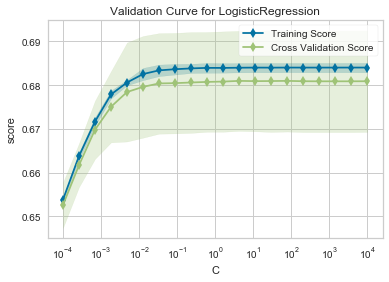

In [32]:
# Create the validation curve visualizer
cv = StratifiedKFold(12)

viz = ValidationCurve(
    LogisticRegression(), param_name="C", param_range=np.logspace(-4, 4, 20),
    logx=True, cv=cv, scoring="f1_weighted", n_jobs=8,
)

viz.fit(X, y)
viz.poof()

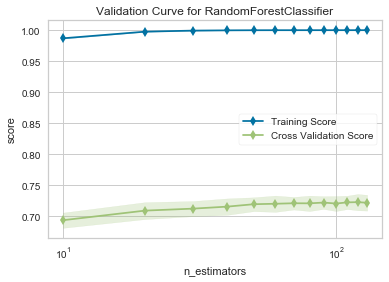

In [35]:
viz = ValidationCurve(
    RandomForestClassifier(), param_name="n_estimators", param_range=list(range(10,131,10)),
    logx=True, cv=cv, scoring="f1_weighted", n_jobs=8,
)

viz.fit(X, y)
viz.poof()

In [20]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

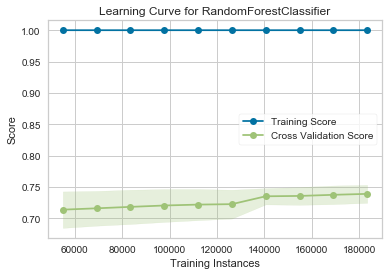

In [23]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=100)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

In [ ]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

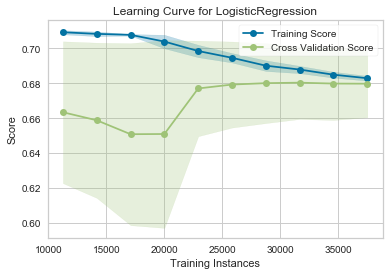

In [45]:
# Instantiate the classification model and visualizer
model = LogisticRegression(max_iter=6000)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

In [ ]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))
f
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

The last step is to save our model to disk for reuse later, with the `pickle` module:

In [ ]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(census)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [ ]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=dataset):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid, choose one of {}".format(valid))
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)